# Load image

num GPUs 0
Dimensions of input image: (3, 128, 128)


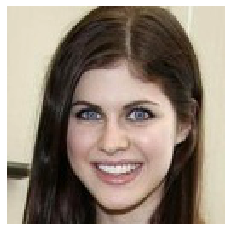

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from sklearn import linear_model

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time

#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '_128x128' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
#if dataset == 'celeba':
#    img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)
img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size



In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable
import torch.optim as optim

use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)


Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


# Construct latent vector z. Compute and visualize G(z)

In [ ]:
G = model.netG
z = torch.zeros(1,model.config.noiseVectorDim)
gen_image = G(z)



grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
# plt.show()

# Compressed sensing

## A=I. Recover G0 (naive)

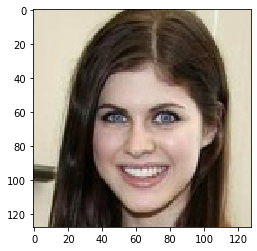

In [12]:
from torch.autograd import Variable
import torch.optim as optim

G = model.netG
mse = torch.nn.MSELoss()

#G0 = G(torch.zeros(1,model.config.noiseVectorDim))
G0 = img_var

z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
#gen_image = G(z)
grid = torchvision.utils.make_grid(G0.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
#plt.show()


def exp_lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=15, factor=0.7):
    """Decay learning rate by a factor of 0.5 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLR is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def fit(num_iter = 4000, lr_decay_epoch = 400):
    optimizer = optim.Adam([z], lr=0.01)
    for i in range(num_iter):
        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch=lr_decay_epoch, factor=0.9)
            
        #################
        def closure():
            optimizer.zero_grad()           
            x = G(z)
            loss = mse(x, G0)
            loss.backward(retain_graph=True)
            print('loss = {}'.format(loss))
            return loss

        loss = optimizer.step(closure)
    print('-' * 50)
    print('loss = {}'.format(loss))

In [13]:
#optimizer = optim.Adam([z], lr=0.1)
#num_iter = 60
#lr_decay_epoch = 20


    #print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')

fit(numiter = 4000, lr_decay_epoch = 400)

print('done')


LR is set to 0.1


loss = 0.8842313885688782
loss = 0.4766038954257965
loss = 0.29755064845085144
loss = 0.17541617155075073
loss = 0.12181907147169113
loss = 0.10660838335752487
loss = 0.11068207025527954
loss = 0.11531949043273926
loss = 0.11735793203115463
loss = 0.11681443452835083
loss = 0.11485324054956436
loss = 0.11302266269922256
loss = 0.11185548454523087
loss = 0.11090777069330215
loss = 0.109505794942379
loss = 0.10734707117080688
loss = 0.10450702160596848
loss = 0.10155195742845535
loss = 0.09895709902048111
loss = 0.09676631540060043
loss = 0.09471201151609421
loss = 0.09272740036249161
loss = 0.09088220447301865
loss = 0.08937332779169083
loss = 0.08812788128852844
loss = 0.0870172381401062
loss = 0.08608221262693405
loss = 0.08527413010597229
loss = 0.08456598967313766
loss = 0.08396518230438232
loss = 0.08338581770658493
loss = 0.08285944163799286
loss = 0.08232845366001129
loss = 0.08175981044769287
loss = 0.08117222785949707
loss = 0.08056161552667618
loss = 0.0799

loss = 0.04538949951529503
loss = 0.04535138979554176
loss = 0.045313429087400436
loss = 0.04527546092867851
loss = 0.045237500220537186
loss = 0.04519938305020332
loss = 0.04516083374619484
loss = 0.04512201249599457
loss = 0.045082997530698776
loss = 0.045043766498565674
loss = 0.04500415921211243
loss = 0.044964488595724106
loss = 0.04492411017417908
loss = 0.04488364979624748
loss = 0.04484274983406067
loss = 0.044801872223615646
loss = 0.04476126655936241
loss = 0.044720906764268875
loss = 0.04468004032969475
loss = 0.044638741761446
loss = 0.04459776356816292
loss = 0.04455648735165596
loss = 0.04451476410031319
loss = 0.044472407549619675
loss = 0.04443005844950676
loss = 0.04438668116927147
loss = 0.04434271529316902

LR is set to 0.016777216000000008


loss = 0.04429817572236061
loss = 0.04426229000091553
loss = 0.044226307421922684
loss = 0.044190388172864914
loss = 0.04415440931916237
loss = 0.044117797166109085
loss = 0.044081371277570724
loss = 0.0440455786883831
loss = 0.

tensor([[[[ 9.4979e-03, -6.0256e-02, -3.1469e-02,  ..., -1.8635e-01,
           -1.1727e-01, -2.5482e-01],
          [-9.1067e-02, -5.1478e-02, -4.0028e-02,  ..., -1.1574e-01,
           -9.6950e-02, -2.5106e-01],
          [-8.6506e-02, -3.9672e-02, -5.7524e-02,  ..., -8.2913e-02,
           -7.5349e-02, -2.0387e-01],
          ...,
          [-7.5051e-02, -1.4429e-01, -2.4108e-01,  ..., -1.6606e-01,
           -1.8604e-01, -2.5953e-01],
          [-9.3638e-02, -1.4130e-01, -2.6119e-01,  ..., -1.8034e-01,
           -2.2677e-01, -3.3551e-01],
          [-1.0451e-01, -1.1520e-01, -2.0317e-01,  ..., -1.8664e-01,
           -2.7824e-01, -3.4138e-01]],

         [[ 9.6351e-02,  1.5867e-04,  1.1390e-02,  ..., -6.7940e-02,
            4.1389e-04, -1.2190e-01],
          [-3.4025e-02, -2.8363e-03, -7.4989e-04,  ...,  1.0362e-03,
            3.3526e-02, -1.0807e-01],
          [-5.1445e-02, -2.9624e-04, -2.4741e-02,  ...,  3.5357e-02,
            4.2979e-02, -9.1105e-02],
          ...,
     

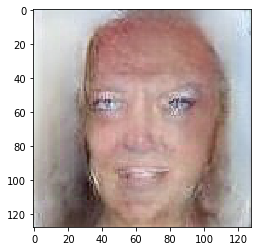

In [14]:
gen_image = G(z)


grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

print(gen_image-G0)


In [ ]:
G = model.netG
mse = torch.nn.MSELoss()

G0 = G(torch.zeros(1,model.config.noiseVectorDim))
d_image = G0.numel()
x = G0.reshape(d_image)

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A
A = torch.randn(m_image, d_image)
y = torch.matmul(A,x)

x_var = torch.zeros(d_image)
y_var = torch.zeros(m_image)

z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
print('start')
# optimization min ||AG(z)-AG0||

for t in range(10):
    print('-' * 50)
    
    lr = 0.05
    v = x - lr*torch.matmul(A.transpose(), torch.matmul(A,x)-y)
    
    # minimize ||G(z)-v||
    optimizer = optim.Adam([z], lr=0.09)
    for i in range(10):
        optimizer.zero_grad()
        loss = mse(G(z), v)
        print(t, loss)
        loss.backward(retain_graph=True)
        optimizer.step()
        print('end epoch')

x_hat = G(z)
#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

In [ ]:
G = model.netG
mse = torch.nn.MSELoss()

G0 = G(torch.zeros(1,model.config.noiseVectorDim))
d_image = G0.numel()
x = G0.reshape(d_image)

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A
A = torch.randn(m_image, d_image)
y = torch.matmul(A,x)

# optimization min ||AG(z)-AG0||
z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
optimizer = optim.Adam([z], lr=0.09)
for t in range(10):
    print('-' * 50)
    optimizer.zero_grad()
    x_var = G(z).reshape(d_image)
    y_var = torch.matmul(A,x_var)
    loss = mse(y_var, y)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

x_hat = G(z)
#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
# plt.show()
#print(Ameas.shape)
# measurements : y = A*x
#img_var_meas = torch.matmul(Ameas_var,img_var.to(device).reshape(d_image,1))



In [ ]:
import time
import torch

t0 = time.time()

x = torch.randn(50000)
A = torch.randn(10000,50000)
y = torch.matmul(A,x)

t1 = time.time()
print('\ntime elapsed:',t1-t0)

In [ ]:
'''
optimizer = optim.Adam([z], lr=0.09)
for t in range(10):
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')
    
optimizer = optim.Adam([z], lr=0.06)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

optimizer = optim.Adam([z], lr=0.03)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

optimizer = optim.Adam([z], lr=0.01)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
'''